# Homework 01: Multivariate Parametric Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

## Generating Random Points

In [2]:
np.random.seed(421)

data_1 = np.random.multivariate_normal(mean=np.array([+0.0, +2.5]), cov=np.array([[+3.2, +0.0], [+0.0, +1.2]]), size=120)
data_2 = np.random.multivariate_normal(mean=np.array([-2.5, -2.0]), cov=np.array([[+1.2, +0.8], [+0.8, +1.2]]), size=80)
data_3 = np.random.multivariate_normal(mean=np.array([+2.5, -2.0]), cov=np.array([[+1.2, -0.8], [-0.8, +1.2]]), size=100)

X = np.vstack([data_1, data_2, data_3]) # data matrix
y = np.concatenate([np.repeat(1, data_1.shape[0]), np.repeat(2, data_2.shape[0]), np.repeat(3, data_3.shape[0])])

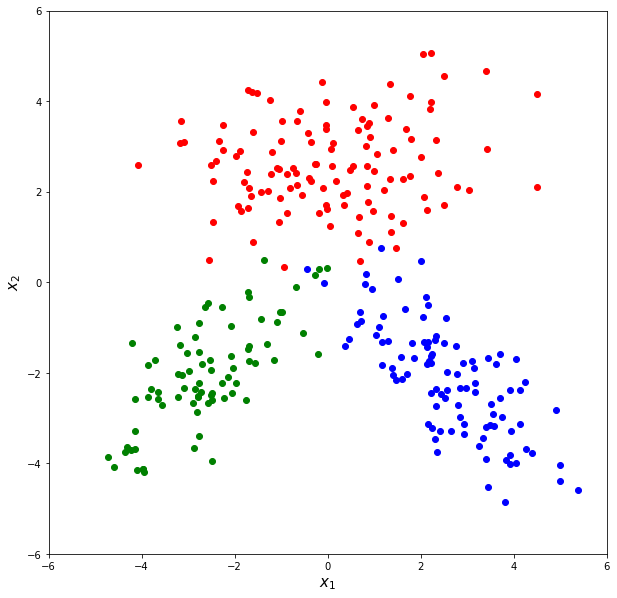

In [3]:
plt.figure(figsize = (10, 10))
plt.plot(data_1[:,0], data_1[:,1], 'ro')
plt.plot(data_2[:,0], data_2[:,1], 'go')
plt.plot(data_3[:,0], data_3[:,1], 'bo')
plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_2$", fontsize=15)
plt.xlim(-6, +6)
plt.ylim(-6, +6)
plt.show()

## Estimating the Parameters

### Sample Mean 
Sample mean, $\textbf{m}: m_i =\frac{\sum_{t-1}^{N}x^t_i}{N}, i=1,...,d$

In [4]:
def estimate_sample_mean(data):
    return [np.sum(data[:, i]) / data.shape[0] for i in range(data.shape[1])]

In [5]:
sample_means = np.array([estimate_sample_mean(data) for data in [data_1, data_2, data_3]])
print(sample_means)

[[ 0.04453807  2.61225128]
 [-2.65871583 -2.04611631]
 [ 2.56054453 -2.12492713]]


### Sample Covariance Matrix

Sample covariance matrix, $\textbf{S}: s_{ij} =\frac{\sum_{t-1}^{N}(x^t_i-m_i)(x_j^t-m_j)}{N}$

In [6]:
def estimate_covariance_matrix(data):
    return np.array([
        np.sum((data[:, 0] - estimate_sample_mean(data)[0]) * (data[:, 0] - estimate_sample_mean(data)[0])) / data.shape[0],
        np.sum((data[:, 0] - estimate_sample_mean(data)[0]) * (data[:, 1] - estimate_sample_mean(data)[1])) / data.shape[0],
        np.sum((data[:, 1] - estimate_sample_mean(data)[1]) * (data[:, 0] - estimate_sample_mean(data)[0])) / data.shape[0],
        np.sum((data[:, 1] - estimate_sample_mean(data)[1]) * (data[:, 1] - estimate_sample_mean(data)[1])) / data.shape[0]
    ]).reshape(2, 2)

In [7]:
sample_covariances = np.array([estimate_covariance_matrix(data) for data in [data_1, data_2, data_3]])
print(sample_covariances)

[[[ 2.81619317  0.22436503]
  [ 0.22436503  1.00404699]]

 [[ 1.42028631  1.01066166]
  [ 1.01066166  1.36103133]]

 [[ 1.40686631 -1.07838138]
  [-1.07838138  1.5075388 ]]]


### Prior Probabilities

$\hat{P}(C_i) = \frac{\sum_t{r_i^t}}{N}$

In [8]:
def prior_probability(data, X):
    return data.shape[0] / X.shape[0]

In [9]:
class_priors = [prior_probability(data, X) for data in [data_1, data_2, data_3]]
print(class_priors)

[0.4, 0.26666666666666666, 0.3333333333333333]


## Calculating Confusion Matrix

### Quadratic Discriminant

Score function: $ g_i(\textbf{x}) = -\frac{1}{2}log|\textbf{S}_i|-\frac{1}{2}(\textbf{x}-\textbf{m}_i)^T\textbf{S}_i^{-1}(\textbf{x}-\textbf{m}_i)+log\hat{P}(C_i)$

In [10]:
def quadratic_discriminant(x, sample_covariance, sample_mean, class_prior):
    return - (1/2 * np.log(np.linalg.det(sample_covariance))) - (1/2 * ((x - sample_mean) @ np.linalg.inv(sample_covariance) @ (x - sample_mean).T)) + (np.log(class_prior))

### Algorithm

Calculate scores of x's for each class. Pick the class with the highest score.

In [11]:
def predict(x):
    g1 = quadratic_discriminant(x, sample_covariances[0], sample_means[0], class_priors[0])
    g2 = quadratic_discriminant(x, sample_covariances[1], sample_means[1], class_priors[1])
    g3 = quadratic_discriminant(x, sample_covariances[2], sample_means[2], class_priors[2])
    
    if g1 > g2 and g1 > g3:
        return 1
    elif g2 > g1 and g2 > g3:
        return 2
    else:
        return 3

In [12]:
y_pred = np.array([predict(x) for x in X])

### Confusion Matrix

In [13]:
confusion_matrix = pd.crosstab(y_pred, y, rownames = ["y_pred"], colnames = ["y_truth"])
display(confusion_matrix)

y_truth,1,2,3
y_pred,,,
1,118,1,1
2,1,78,1
3,1,1,98


## Drawing Decision Boundaries

### Quadratic Discriminant

$g_i(x) = x^TW_ix + w_i^Tx + w_{i0}$

where

$\newline$
$ W_i = -\frac{1}{2}S_i^{-1}$

$ w_i = S_i^{-1}m_i$

$ w_{i0} = -\frac{1}{2}m_i^TS_i^{-1}m_i -\frac{1}{2}log|S_i| + log\hat{P}(C_i)$

In [14]:
def Wi(sample_covariance):
    return -1/2 * np.linalg.inv(sample_covariance)

In [15]:
W1, W2, W3 = [Wi(sample_covariance) for sample_covariance in sample_covariances]

print(f"W1:\n{W1}\n")
print(f"W2:\n{W2}\n")
print(f"W3:\n{W3}")

W1:
[[-0.18076276  0.04039337]
 [ 0.04039337 -0.50701099]]

W2:
[[-0.74649281  0.55432351]
 [ 0.55432351 -0.77899274]]

W3:
[[-0.78681636 -0.56283003]
 [-0.56283003 -0.73427326]]


In [16]:
def wi(sample_covariance, sample_mean):
    return np.linalg.inv(sample_covariance) @ sample_mean

In [17]:
w1, w2, w3 = [wi(sample_covariance, sample_mean) for sample_covariance, sample_mean in zip(sample_covariances, sample_means)]

print(f"w1:\n{w1}\n")
print(f"w2:\n{w2}\n")
print(f"w3:\n{w3}")

w1:
[-0.19493362  2.64528214]

w2:
[-1.70100375 -0.2402421 ]

w3:
[ 1.63741104 -0.23825162]


In [18]:
def wi0(sample_covariance, sample_mean, class_prior):
    return - (1/2 * (sample_mean.T @ np.linalg.inv(sample_covariance) @ sample_mean)) - (1/2 * np.log(np.linalg.det(sample_covariance))) + np.log(class_prior)

In [19]:
w10, w20, w30 = [wi0(sample_covariance, sample_mean, class_prior) for sample_covariance, sample_mean, class_prior in zip(sample_covariances, sample_means, class_priors)]

print(f"w10:\n{w10}\n")
print(f"w20:\n{w20}\n")
print(f"w30:\n{w30}")

w10:
-4.877751288835391

w20:
-3.782512703335696

w30:
-3.4266236948916866


In [20]:
x1_interval = np.linspace(-6, +6, 1200)
x2_interval = np.linspace(-6, +6, 1200)
x1_grid, x2_grid = np.meshgrid(x1_interval, x2_interval)

In [21]:
discriminant_values_1 = (x1_grid * W1[0, 0] * x1_grid.T) + (x1_grid * W1[0, 1] * x1_grid.T) + (x2_grid * W1[1, 0] * x2_grid.T) + (x2_grid * W1[1, 1] * x2_grid.T) + (w1[0] * x1_grid) + (w1[1] * x2_grid) + w10
discriminant_values_2 = (x1_grid * W2[0, 0] * x1_grid.T) + (x1_grid * W2[0, 1] * x1_grid.T) + (x2_grid * W2[1, 0] * x2_grid.T) + (x2_grid * W2[1, 1] * x2_grid.T) + (w2[0] * x1_grid) + (w2[1] * x2_grid) + w20
discriminant_values_3 = (x1_grid * W3[0, 0] * x1_grid.T) + (x1_grid * W3[0, 1] * x1_grid.T) + (x2_grid * W3[1, 0] * x2_grid.T) + (x2_grid * W3[1, 1] * x2_grid.T) + (w3[0] * x1_grid) + (w3[1] * x2_grid) + w30

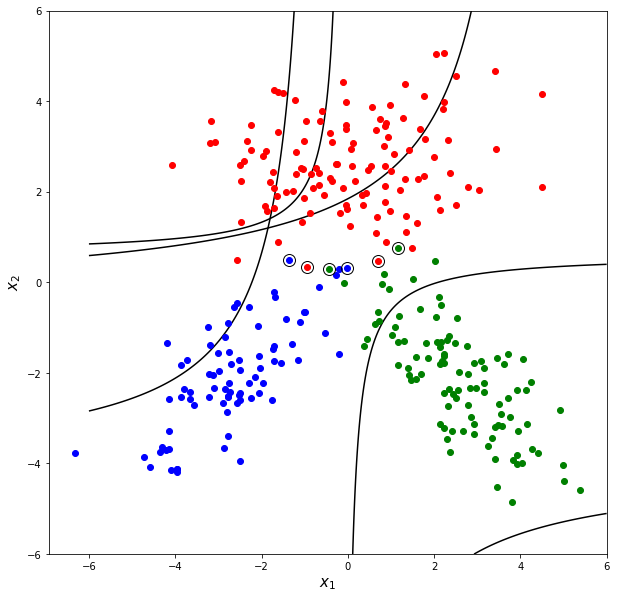

In [22]:
plt.figure(figsize = (10, 10))
plt.plot(X[y == 1, 0], X[y == 1, 1], "ro")
plt.plot(X[y == 2, 0], X[y == 2, 1], "bo")
plt.plot(X[y == 3, 0], X[y == 3, 1], "go")
plt.plot(X[y_pred != y, 0], X[y_pred != y, 1], "ko", markersize = 12, fillstyle = "none")
plt.contour(x1_grid, x2_grid, discriminant_values_1, levels = 0, colors = "k")
plt.contour(x1_grid, x2_grid, discriminant_values_2, levels = 0, colors = "k")
plt.contour(x1_grid, x2_grid, discriminant_values_3, levels = 0, colors = "k")
plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_2$", fontsize=15)

plt.show()

In [23]:
discriminant_values_1 = (w1[0] * x1_grid) + (w1[1] * x2_grid) + w10
discriminant_values_2 = (w2[0] * x1_grid) + (w2[1] * x2_grid) + w20
discriminant_values_3 = (w3[0] * x1_grid) + (w3[1] * x2_grid) + w30

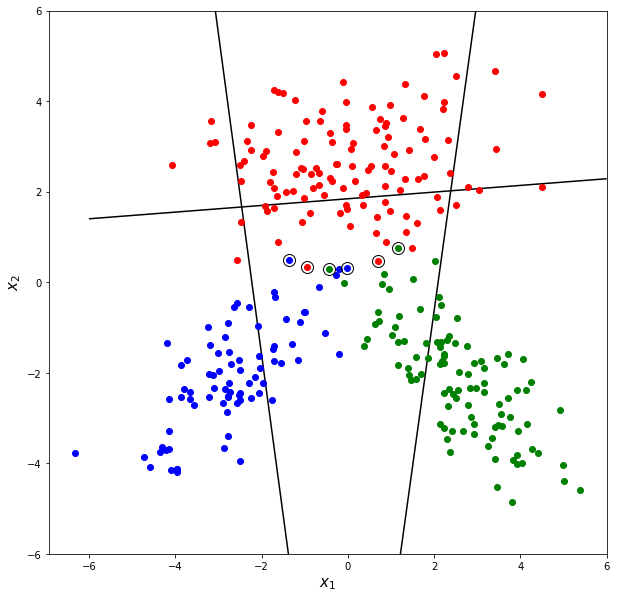

In [24]:
plt.figure(figsize = (10, 10))
plt.plot(X[y == 1, 0], X[y == 1, 1], "ro")
plt.plot(X[y == 2, 0], X[y == 2, 1], "bo")
plt.plot(X[y == 3, 0], X[y == 3, 1], "go")
plt.plot(X[y_pred != y, 0], X[y_pred != y, 1], "ko", markersize = 12, fillstyle = "none")
plt.contour(x1_grid, x2_grid, discriminant_values_1, levels = 0, colors = "k")
plt.contour(x1_grid, x2_grid, discriminant_values_2, levels = 0, colors = "k")
plt.contour(x1_grid, x2_grid, discriminant_values_3, levels = 0, colors = "k")
plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_2$", fontsize=15)

plt.show()